In [24]:
import pandas as pd
import numpy as np 

import pingouin as pg

from collections import defaultdict
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score

from sklearn.decomposition import TruncatedSVD


from sklearn.cluster import KMeans

import seaborn as sns

import imp
import bullets


DIR = "/home/bryce/Projects/Data_Science/Apt_Prices/csvs/march8/"

In [25]:
blurb_csv = DIR + "pd_address_info.csv"
apt_csv = DIR + 'pd_apt_info.csv'
apt_df = pd.read_csv(apt_csv, sep=';')
df = pd.read_csv(blurb_csv, sep=';', usecols=['address', 'url', 'title', 'bullets', 'blurb', 'latlng'])

In [61]:
df.title.to_csv('/tmp/title.csv')

In [26]:
def get_property_type(title):
    m = re.match(r'.* ([A-Za-z]+) for Rent.*', title)
    if m is None:
        return 'undefined'
    type = m.group(1).lower()
    if type == 'houses':
        type = 'house'
    return type

df['type'] = df.title.map(get_property_type)

def is_house(type):
    return 1 if type in ['townhouse', 'house'] else 0

df['is_house'] = df.type.map(is_house)
df.is_house.describe()

count    433.000000
mean       0.501155
std        0.500577
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: is_house, dtype: float64

In [65]:
df.type.value_counts()

house        181
undefined    174
townhouse     36
condo         31
apartment     11
Name: type, dtype: int64

In [27]:
def bullets_to_set(bullets_str):
    if bullets_str is None:
        return []
    
    bullets_str = str(bullets_str)

    bullets = bullets_str.split('()')[1:]

    discard_characters_re = r'[^\d\sa-z]'
    bullets = [b.strip().lower() for b in bullets]
    bullets = [re.sub(discard_characters_re, '', b) for b in bullets]
    return set(bullets)

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])



# def get_rows_with_bullet(df, bullet_str, bullet_re = None):


In [28]:
df['bullets_set'] = df.bullets.map(bullets_to_set)


In [29]:
def get_frequent_terms(df, min_count = 1):
    term_to_count = to_1D(df.bullets_set).value_counts().to_dict()
    freq_terms = term_to_count
    terms_to_remove = []
    for t, c in freq_terms.items():
        if c < min_count:
            terms_to_remove.append(t)
    for t in terms_to_remove:
        freq_terms.pop(t)
    return freq_terms

Here is my idea. Looking at the bullets, there aren't that many. Maybe they're pre-selected from a list that apartments.com supplies? So, let's do the following:

- For addresses without bullets, look through the blurb to see if each bullet is present. If it is, add it to that address's bullets list
- Then, keep only bullets with a count higher than N
- For these bullets, calculate the correlation between the presence of the bullet and the price of the apartment
- Keep the M bullets with the highest correlation.

Another thing we could try is look at blurbs that are NOT correlated with the other features very much. Compute the correlation between each blurb dummy variable and:
- zip
- units_in_building
- neighborhood

exclude any blurbs with high correlation to any of those.

Maybe we could try BOTH - pick the blurbs correlated with rent, but not very correlated with other variables.

In [30]:
freq_terms = get_frequent_terms(df)


BLURB_SPECIFIC_BULLETS = {'en suite', 'penthouse', 'family home', 'fully furnished'}

# for these bullets, we need to check the first one before adding the second, since the second is a subphrase of the first
SPECIAL_BULLETS = [
    ('no pets allowed', 'pets allowed'),
    ('no dogs allowed', 'dogs allowed'),
    ('no cats allowed', 'cats allowed'),
    ('furnished units available', 'furnished')
]

# we should make this method clean up the blurb further
def generate_bullets_from_blurb(row):
    if len(row.bullets_set) > 0:
        return pd.NA

    blurb = str(row.blurb).lower()
    terms = set()
    for term in freq_terms:
        if blurb.find(term) != -1:
            terms.add(term)
            
    for term in BLURB_SPECIFIC_BULLETS:
        if term in blurb:
            terms.add(term)

    fua = 'furnished units available'
    f = 'furnished'
    if fua in terms:
        terms.remove(f)
    
    for bullet_pair in SPECIAL_BULLETS:
        (b1, b2) = bullet_pair 
        if b1 in blurb:
            terms.add(b1)
        elif b2 in blurb:
            terms.add(b2)
    
    return terms 

def remove_infrequent_terms(bullets_set):
    bullets_to_remove = set()
    for bullet in bullets_set:
        if bullet not in freq_terms:
            bullets_to_remove.add(bullet)
    return bullets_set - bullets_to_remove 
    



In [18]:
# Bryce - scratch, delete this

import csv 

with open('/home/bryce/Projects/Data_Science/Apt_Prices/scratch/march8/training_bullet_counts.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for k, v in freq_terms.items():
        writer.writerow([k, v])

In [31]:
# generate the bullets from blurbs for addresses missing bullets, and combined the two forms of bullets into one row


df['bullets_set_from_blurb'] = df.apply(generate_bullets_from_blurb, axis=1)
df['bullets_set'] = df.bullets_set.map(remove_infrequent_terms)
df['combined_bullets_set'] = np.where(df.bullets_set_from_blurb.isna(), df.bullets_set, df.bullets_set_from_blurb)
def bullets_set_to_string(bullets):
    return '|'.join(bullets)

df['combined_bullets'] = df.combined_bullets_set.map(bullets_set_to_string)

In [43]:
# should we add 'kitchen' : -1 ?
KITCHEN_QUALITY_MAP = {'stainless steel appliances' : 1,
                       'granite countertops' : 2,
                       'breakfast nook' : 1,
                       'island kitchen': 1}

SECURITY_TERMS = {'gated', 'controlled access'}
LAWN_TERMS = {'lawn', 'yard'}
PETS_ALLOWED_TERMS = {'dogs allowed', 'cats allowed', 'pet play area', 'pet washing station'}
NO_PETS_ALLOWED_TERMS = {'no dogs allowed', 'no cats allowed', 'no pets allowed', 'pets not allowed'}
UPSCALE_DETAILS_MAP = {'tile floors' : 1,
                       'hardwood floors' : 1,
                       'double pane windows' : 1,
                       'vaulted ceilings' : 1,
                       'crown molding' : 1,
                       'builtin bookshelves' : 1}
POOL_TERMS = {'pool', 'swimming pool'}
ELEVATOR_TERMS = {'elevator'}
LUXURY_DETAILS_MAP = {'roof terrace' : 1,
                      'spa' : 1,
                      'concierge' : 1,
                      'onsite retail' : 1,
                      'penthouse' : 2,
                      'pet care' : 1}
WATERFRONT_TERMS = {'waterfront', 'dock'}
RECREATION_DETAILS_MAP = {'fitness center' : 1,
                          'tennis courts' : 1,
                          'volleyball court' : 1,
                          'basketball court' : 0.5}

FURNISHED_TERMS = {'furnished', 'fully furnished'}


FEATURE_TO_TERMS_MAP = {
    'has_security' : SECURITY_TERMS,
    'has_lawn' : LAWN_TERMS,
    'are_pets_allowed' : PETS_ALLOWED_TERMS,
    'are_no_pets_allowed' : NO_PETS_ALLOWED_TERMS,
    'has_pool' : POOL_TERMS,
    'is_waterfront' : WATERFRONT_TERMS,
    'is_furnished' : FURNISHED_TERMS,
    'has_elevator' : ELEVATOR_TERMS,
    'kitchen_quality_score' : KITCHEN_QUALITY_MAP,
    'upscale_score' : UPSCALE_DETAILS_MAP,
    'recreation_score' : RECREATION_DETAILS_MAP,
    'luxury_score' : LUXURY_DETAILS_MAP
}



def compute_score(bullets_set, term_to_score_map):
    score = 0.0
    for bullet in bullets_set:
        if bullet in term_to_score_map:
            score += term_to_score_map[bullet]
    return score 

def compute_bool(bullets_set, terms_set):
    for bullet in bullets_set:
        if bullet in terms_set:
            return 1
    return 0


def add_bullet_features(df):
    # Note that terms will either be a set or a map, depending on whether we're computing a score or a boolean.
    for feat_name, terms in FEATURE_TO_TERMS_MAP.items():
        if feat_name.endswith('_score'):
            df[feat_name] = df.combined_bullets_set.map(lambda bullets_set : compute_score(bullets_set, terms))
        else:
            df[feat_name] = df.combined_bullets_set.map(lambda bullets_set : compute_bool(bullets_set, terms))

#add_bullet_features(df)


In [42]:
# Let's look at these features we added 

df.luxury_score.value_counts()


0.0    334
1.0     90
2.0      7
3.0      2
Name: luxury_score, dtype: int64

In [13]:
df_with_dummies =  pd.concat((df, df.combined_bullets.str.get_dummies(sep='|')), axis=1)
df_with_dummies = pd.merge(df_with_dummies, apt_df, on='address')

In [79]:
just_dummies = df_with_dummies.drop(columns=['address', 'url', 'title', 'bullets', 'blurb', 'latlng', 'bullets_set', 'bullets_set_from_blurb', 'combined_bullets', 'bullets_set_from_blurb', 'combined_bullets_set', 'price', 'beds', 'baths', 'sq_ft', 'location', 'zip', 'units_in_building', 'type', 'is_house'])
# normally corrwith matches up the column names between the calling df and the argument df.
# but if you make the argumenet a series, it broadcasts this to all columns of the calling df.
# this isn't documented, so just noting it here!
corrs = just_dummies.corrwith(df_with_dummies.price)

dummy_cols = list(just_dummies.columns)
controlled_corrs = pg.pairwise_corr(df_with_dummies, columns=[dummy_cols, ['price']], covar=['sq_ft', 'beds', 'baths', 'zip', 'is_house'])

/tmp/ipykernel_3595/3146290594.py:5: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = just_dummies.corrwith(df_with_dummies.price)
/home/bryce/.local/lib/python3.8/site-packages/pingouin/pairwise.py:1429: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  stats = stats[~stats[["X", "Y"]].isin(covar).any(1)]


In [139]:
term_to_count = to_1D(df.bullets_set).value_counts().to_dict()
bullet_dummy_vars = df.combined_bullets.str.get_dummies(sep='|')
svd = TruncatedSVD(n_components=26)
svd_matrix = svd.fit_transform(bullet_dummy_vars)



(433, 6)


0.7372216697490305


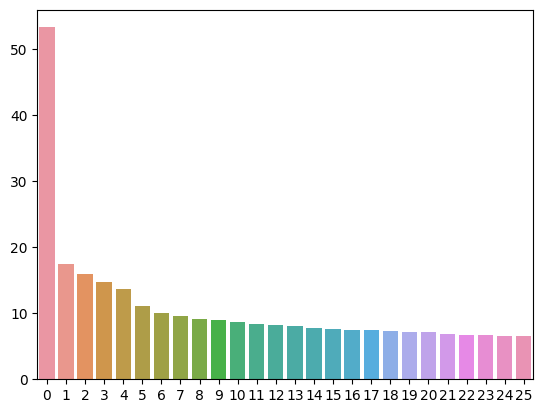

In [140]:
Sigma = svd.singular_values_
V_T = svd.components_.T
sns.barplot(x=list(range(len(Sigma))), y = Sigma)
print(svd.explained_variance_ratio_.sum())
term_topic_matrix = pd.DataFrame(data=V_T, index=bullet_dummy_vars.columns, columns=[f'Latent_concept_{i}' for i in range(0, V_T.shape[1])])

(107,)


<AxesSubplot: >

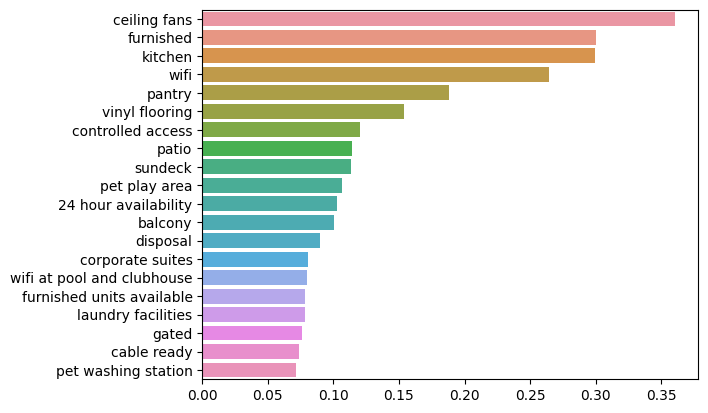

In [144]:
data = term_topic_matrix[f'Latent_concept_20']
data = data.sort_values(ascending=False)
print(data.shape)
top_10 = data[:20]
bottom_10 = data.iloc[-15:]
sns.barplot(x= top_10.values, y=top_10.index)
#sns.barplot(x=bottom_10.values, y=bottom_10.index)

In [80]:
controlled_corrs.sort_values(by='r', inplace=True)
print(controlled_corrs.tail())

controlled_corrs.to_csv('/tmp/controlled_corrs4.csv', sep=';', index=False, columns=['X', 'Y', 'r', 'CI95%'])


                              X      Y   method  \
9                  ceiling fans  price  pearson   
44                    microwave  price  pearson   
35        in unit washer  dryer  price  pearson   
76                        views  price  pearson   
81  wheelchair accessible rooms  price  pearson   

                                            covar alternative     n         r  \
9   ['sq_ft', 'beds', 'baths', 'zip', 'is_house']   two-sided  2720  0.185821   
44  ['sq_ft', 'beds', 'baths', 'zip', 'is_house']   two-sided  2720  0.219576   
35  ['sq_ft', 'beds', 'baths', 'zip', 'is_house']   two-sided  2720  0.236507   
76  ['sq_ft', 'beds', 'baths', 'zip', 'is_house']   two-sided  2720  0.308957   
81  ['sq_ft', 'beds', 'baths', 'zip', 'is_house']   two-sided  2720  0.314095   

           CI95%         p-unc  
9   [0.15, 0.22]  1.622783e-22  
44  [0.18, 0.26]  5.362979e-31  
35   [0.2, 0.27]  7.912442e-36  
76  [0.27, 0.34]  3.907167e-61  
81  [0.28, 0.35]  3.133081e-63  


We're getting a little lost in the weeds here. Here are some things we should do:

- Write a function that takes in a list of bullets, and prints average price for units with and without that bullet, grouped by zip, beds, baths, and type. Just to double check the sanity of the correlations we're getting.
- A lot of the bullets are probably highly correlated with each other. We'd ideally pick out bullets that aren't so correlated with each other to be the features.

- This reminds me of the most informative base pairs. Pick the bullet with the highest average mutual information with the other bullets. Divide units into two - those with and without this bullet. Repeat.
- We could do dimensionality reduction on the bullets.
- Look at correlation matrix. 

In [87]:
# term_cors = pg.pairwise_corr(df_with_dummies, columns=dummy_cols)
term_cors.sort_values(by='r', inplace=True)
term_cors.to_csv('/tmp/term_corrs.csv', sep=';', columns=['X', 'Y', 'r'])

In [160]:
bullet_features = bullets.BulletFeatures()
training_dummies = bullet_features.generate_training_bullet_dummy_vars(df)
testing_dummies = bullet_features.generate_testing_bullet_dummy_vars(df)
training_svd_df = bullet_features.get_training_svd_df(df)
print(training_svd_df.shape)
testing_svd_df = bullet_features.get_testing_svd_df(df)
testing_svd_df.equals(training_svd_df)

(433, 15)


True